In [ ]:
# default_exp datos

# Datos

> Cargar y preparar datos de rezago social, pobreza, salud, y de infraestructura de México. 

In [ ]:
#hide
from nbdev.showdoc import *

# Bibliotecas

In [ ]:
# export
import os
import glob
import itertools
from fastcore.test import *
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import timedelta, date, datetime
import csv

import seaborn as sns
import requests

import logging

In [ ]:
pd.__version__

'1.1.3'

## Utilería

In [ ]:
#exports
DATA_DIR_COVID = 'datos/secretaria_salud/'


In [ ]:
#exports
def asegura_archivos_covid_disponibles(fechas):
    '''
    Esta función genera un error si no están disponibles todos los archivos de casos COVID-19 en México
    de las fechas especificadas. Los nombres de archivos siguen el patrón con el que los publica la Secretaría de Salud:
    {AÑO}{MES}{DIA}COVID19MEXICO.csv.zip, por ejemplo 200413COVID19MEXICO.csv.zip
    '''
    for fecha in fechas:
        fecha_str = fecha.strftime("%y%m%d")
        file = os.path.join(DATA_DIR_COVID, f'{fecha_str}COVID19MEXICO.csv.zip')
        assert os.path.exists(file), f'{fecha_str} no disponible'


In [ ]:
inicio = pd.to_datetime('200428', yearfirst=True)
fin = pd.to_datetime('200608', yearfirst=True)

asegura_archivos_covid_disponibles(pd.date_range(inicio, fin))

### columnas_comunes

In [ ]:
# exports

def columnas_comunes(df_1, df_2):
    '''
    Obtiene la lista de columnas con el mismo nombre entre dos DataFrame
    '''
    return list(set(df_1.columns).intersection(df_2.columns))

### arregla_cvegeo

In [ ]:
#exports

def arregla_cvegeo(df, campo_cvegeo='cvegeo', extraer_ent=False):
    '''
    Revisa que los indetificadores de municipio (clave entidad + clave municipio) tengan 5 digitos, si un identificador
    tiene 4 le agrega un cero. Esta corrección asume que el problema surgió de leer los identificadores como enteros
    lo cual provoca que se descarten los ceros a la izquierda.
    '''
    df[campo_cvegeo] = df[campo_cvegeo].apply(lambda x: '0' + x if len(x) == 4 else x)
    
    if extraer_ent:
        df[f'ent_{campo_cvegeo}'] = df[campo_cvegeo].str[:2]
    return df

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def cross_join(left, right):
    return (left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

def marco_municipal_2019():
    # cuenta número de casos por resultado
    marco_2019 = gpd.read_file('datos/municipios/marco_2019.json')
    marco_2019.rename(columns={'CVE_ENT': 'CLAVE_ENTIDAD_RES',
                               'municipio_cvegeo': 'CLAVE_MUNICIPIO_RES',
                               'municipio_nombre': 'MUNICIPIO_RES'}, inplace=True)
    marco_2019.MUNICIPIO_RES = marco_2019.MUNICIPIO_RES.str.upper()
    
    marco_2019.drop(columns=['CVE_MUN'], inplace=True)
    return marco_2019



## carga_datos_covid19_MX

In [ ]:
# exports

def carga_datos_covid19_MX(fecha='200601', resolver_claves='si_no_binarias'):
    """
        Lee en un DataFrame el CSV con el reporte de casos de la Secretaría de Salud de México publicado en una fecha dada. Esta función
        también lee el diccionario de datos que acompaña a estas publicaciones para preparar algunos campos, en particular permite la funcionalidad
        de generar columnas binarias para datos con valores 'SI', 'No'.

        **Nota**: En esta versión la ruta esta y nombre de los archivos es fija. Asumimos que existe un directorio 'datos/secretaria_salud/'
        donde se encuentran todos los archivos.

        **Nota 2**: El catálogo Resultado_LAB del formato de datos 07-10-2020 tiene el primer renglón vacío, y el catálogo CLASIFICACION
        final tiene los dos primeros renglones vacíos **hay que borrarlos en el archivo**

        periodo: 'dia', 'historico'. Trae los datos de la fecha indicada o trae
        la serie de conjuntos de datos hasta la fecha indicada (por implementar).

        resolver_claves: 'sustitucion', 'agregar', 'si_no_binarias', 'solo_localidades'. Resuelve los valores del conjunto de datos usando el
        diccionario de datos y los catálogos. 'sustitucion' remplaza los valores en las columnas, 'agregar'
        crea nuevas columnas. 'si_no_binarias' cambia valores SI, NO, No Aplica, SE IGNORA, NO ESPECIFICADO por 1, 0, 0, 0, 0 respectivamente.

    """
    nuevo_formato=False
    fecha_carga = pd.to_datetime(fecha, yearfirst=True)

    if fecha_carga < pd.to_datetime('20-10-07', yearfirst=True):
        fecha_formato = '0412'
    elif ((fecha_carga >= pd.to_datetime('20-10-07', yearfirst=True))
          & (fecha_carga < pd.to_datetime('20-11-28', yearfirst=True))):
        fecha_formato = '071020'
        nuevo_formato = True
    else:
        fecha_formato = '201128'
        nuevo_formato = True


    catalogos=f'Catalogos_{fecha_formato}.xlsx'
    descriptores=f'Descriptores_{fecha_formato}.xlsx'

    diccionarios_path = Path('datos/secretaria_salud/diccionario_datos_covid19')
    catalogos = diccionarios_path/catalogos
    data_file = os.path.join(DATA_DIR_COVID, f'{fecha}COVID19MEXICO.csv.zip')
    df = pd.read_csv(data_file, dtype=object, encoding='latin-1')

    # Hay un error y el campo OTRA_COMP es OTRAS_COMP según los descriptores
    df.rename(columns={'OTRA_COM': 'OTRAS_COM'}, inplace=True)

    # Asignar clave única a municipios
    df['MUNICIPIO_RES'] = df['ENTIDAD_RES'] + df['MUNICIPIO_RES']
    df['CLAVE_MUNICIPIO_RES'] = df['MUNICIPIO_RES']

    # Leer catalogos
    nombres_catalogos = ['Catálogo de ENTIDADES',
                         'Catálogo MUNICIPIOS',
                         'Catálogo RESULTADO',
                         'Catálogo SI_NO',
                         'Catálogo TIPO_PACIENTE']

    if nuevo_formato:
        nombres_catalogos.append('Catálogo CLASIFICACION_FINAL')
        nombres_catalogos[2] = 'Catálogo RESULTADO_LAB'

    dict_catalogos = pd.read_excel(catalogos,
                              nombres_catalogos,
                              dtype=str,
                              engine='openpyxl')

    entidades = dict_catalogos[nombres_catalogos[0]]
    municipios = dict_catalogos[nombres_catalogos[1]]
    tipo_resultado = dict_catalogos[nombres_catalogos[2]]
    cat_si_no = dict_catalogos[nombres_catalogos[3]]
    cat_tipo_pac = dict_catalogos[nombres_catalogos[4]]

    if nuevo_formato:
        clasificacion_final = dict_catalogos[nombres_catalogos[5]]


    # Resolver códigos de entidad federal
    cols_entidad = ['ENTIDAD_RES', 'ENTIDAD_UM', 'ENTIDAD_NAC']
    df['CLAVE_ENTIDAD_RES'] = df['ENTIDAD_RES']
    df[cols_entidad] = df[cols_entidad].replace(to_replace=entidades['CLAVE_ENTIDAD'].values,
                                               value=entidades['ENTIDAD_FEDERATIVA'].values)

    # Contruye clave unica de municipios de catálogo para resolver nombres de municipio
    municipios['CLAVE_MUNICIPIO'] = municipios['CLAVE_ENTIDAD'] + municipios['CLAVE_MUNICIPIO']

    # Resolver códigos de municipio
    municipios_dict = dict(zip(municipios['CLAVE_MUNICIPIO'], municipios['MUNICIPIO']))
    df['MUNICIPIO_RES'] = df['MUNICIPIO_RES'].map(municipios_dict.get)

    # Resolver resultados
    if nuevo_formato:
        df.rename(columns={'RESULTADO_LAB': 'RESULTADO'}, inplace=True)
        tipo_resultado['DESCRIPCIÓN'].replace({'POSITIVO A SARS-COV-2': 'Positivo SARS-CoV-2'}, inplace=True)

    tipo_resultado = dict(zip(tipo_resultado['CLAVE'], tipo_resultado['DESCRIPCIÓN']))
    df['RESULTADO'] = df['RESULTADO'].map(tipo_resultado.get)

    # Resolver datos SI - NO

    # Necesitamos encontrar todos los campos que tienen este tipo de dato y eso
    # viene en los descriptores, en el campo FORMATO_O_FUENTE
    descriptores = pd.read_excel(diccionarios_path/descriptores,
                                 index_col='Nº',
                                 engine='openpyxl')
    descriptores.columns = list(map(lambda col: col.replace(' ', '_'), descriptores.columns))
    descriptores['FORMATO_O_FUENTE'] = descriptores.FORMATO_O_FUENTE.str.strip()

    datos_si_no = descriptores.query('FORMATO_O_FUENTE == "CATÁLOGO: SI_ NO"')
    cat_si_no['DESCRIPCIÓN'] = cat_si_no['DESCRIPCIÓN'].str.strip()

    campos_si_no = datos_si_no.NOMBRE_DE_VARIABLE
    nuevos_campos_si_no = campos_si_no

    if resolver_claves == 'agregar':
        nuevos_campos_si_no = [nombre_var + '_NOM' for nombre_var in campos_si_no]
    elif resolver_claves == 'si_no_binarias':
        nuevos_campos_si_no = [nombre_var + '_BIN' for nombre_var in campos_si_no]
        cat_si_no['DESCRIPCIÓN'] = list(map(lambda val: 1 if val == 'SI' else 0, cat_si_no['DESCRIPCIÓN']))

    df[nuevos_campos_si_no] = df[datos_si_no.NOMBRE_DE_VARIABLE].replace(
                                                to_replace=cat_si_no['CLAVE'].values,
                                                value=cat_si_no['DESCRIPCIÓN'].values)

    # Resolver tipos de paciente
    cat_tipo_pac = dict(zip(cat_tipo_pac['CLAVE'], cat_tipo_pac['DESCRIPCIÓN']))
    df['TIPO_PACIENTE'] = df['TIPO_PACIENTE'].map(cat_tipo_pac.get)

    df = procesa_fechas(df)

    return df

### procesa_fechas

In [ ]:
#exports

def procesa_fechas(covid_df):
    df = covid_df.copy()

    df['FECHA_INGRESO'] = pd.to_datetime(df['FECHA_INGRESO'])
    df['FECHA_SINTOMAS'] = pd.to_datetime(df['FECHA_SINTOMAS'])
    df['FECHA_DEF'] = pd.to_datetime(df['FECHA_DEF'], 'coerce')
    df['DEFUNCION'] = (df['FECHA_DEF'].notna()).astype(int)
    df['EDAD'] = df['EDAD'].astype(int)

    df.set_index('FECHA_INGRESO', drop=False, inplace=True)
    df['AÑO_INGRESO'] = df.index.year
    df['MES_INGRESO'] = df.index.month
    df['DIA_SEMANA_INGRESO'] = df.index.weekday
    df['SEMANA_AÑO_INGRESO'] = df.index.week
    df['DIA_MES_INGRESO'] = df.index.day
    df['DIA_AÑO_INGRESO'] = df.index.dayofyear

    return df


In [ ]:
ayer = date.today() - timedelta(days=3)
%time casos_df = carga_datos_covid19_MX(fecha=ayer.strftime('%y%m%d'), resolver_claves='si_no_binarias')

CPU times: user 33.8 s, sys: 5.79 s, total: 39.6 s
Wall time: 40.2 s


In [ ]:
casos_df.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,TOMA_MUESTRA_BIN,MIGRANTE_BIN,UCI_BIN,DEFUNCION,AÑO_INGRESO,MES_INGRESO,DIA_SEMANA_INGRESO,SEMANA_AÑO_INGRESO,DIA_MES_INGRESO,DIA_AÑO_INGRESO
FECHA_INGRESO,,,,,,,,,,,,,,,,,,,,,
2020-03-18,2020-11-01,071735,2,9,PUEBLA,2,PUEBLA,PUEBLA,PUEBLA,AMBULATORIO,...,1,0,0,0,2020,3,2,12,18,78
2020-03-31,2020-11-01,002371,1,4,BAJA CALIFORNIA SUR,2,BAJA CALIFORNIA SUR,BAJA CALIFORNIA SUR,LOS CABOS,AMBULATORIO,...,1,0,0,0,2020,3,1,14,31,91
2020-03-29,2020-11-01,11fb00,1,12,CIUDAD DE MÉXICO,2,CIUDAD DE MÉXICO,CIUDAD DE MÉXICO,CUAUHTÉMOC,AMBULATORIO,...,1,0,0,1,2020,3,6,13,29,89
2020-03-30,2020-11-01,092521,1,12,CIUDAD DE MÉXICO,1,CIUDAD DE MÉXICO,CIUDAD DE MÉXICO,VENUSTIANO CARRANZA,AMBULATORIO,...,1,0,0,0,2020,3,0,14,30,90
2020-04-01,2020-11-01,0955a5,2,12,COLIMA,1,JALISCO,COLIMA,VILLA DE ÁLVAREZ,AMBULATORIO,...,1,0,0,0,2020,4,2,14,1,92


In [ ]:
assert 'CLASIFICACION_FINAL' in carga_datos_covid19_MX(fecha='201007', resolver_claves='si_no_binarias')

In [ ]:
assert 'CLASIFICACION_FINAL' not in carga_datos_covid19_MX(fecha='201006', resolver_claves='si_no_binarias')

In [ ]:
def resolver_clasificacion_casos(casos_df):
    ''' 
        Resuelve según la siguiente regla: las claves 1, 2, 3 se consideran casos positivos; 
        la clave 4, 5, y 6 sospechoso; y 7 negativo.
    
        Referirse al catálogo de datos para más información: 
          'datos/secretaria_salud/diccionario_datos_covid19/Catalogos_071020.xlsx'.
    '''
    # Resolver clasificación final (nuevos resultados)
    tipo_resultado = pd.read_excel('datos/secretaria_salud/diccionario_datos_covid19/Catalogos_071020.xlsx',
                                   'Catálogo CLASIFICACION_FINAL',
                                   dtype=str)
    
    
    casos_df['CLASIFICACION_FINAL'] = casos_df['CLASIFICACION_FINAL'].replace(to_replace=tipo_resultado['CLAVE'].values,
                                                              value=tipo_resultado['CLASIFICACIÓN'].values)

    return casos_df

## actualizar_datos_salud

In [ ]:
# exports

def actualizar_datos_salud(directorio_datos='./datos/secretaria_salud/', fecha_inicio='12-04-2020'):
    '''
        Descarga todos los archivos de datos hasta el día anterior a la fecha actual. Si los archivos
        ya existen en el directorio entonces no los descarga.
    '''
    url_salud_historicos = 'http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/historicos/'    
    ayer = date.today() - timedelta(days=1)
    fecha_inicio = datetime.strptime(fecha_inicio, "%d-%m-%Y")
    for fecha in daterange(fecha_inicio.date(), ayer):
        archivo_nombre = f'{fecha.strftime("%y%m%d")}COVID19MEXICO.csv.zip'
        archivo_ruta = os.path.join(directorio_datos, archivo_nombre)
        if os.path.exists(archivo_ruta):
            logging.debug(f'Ya existe {archivo_nombre}')
        else:
            print(f'Bajando datos {fecha.strftime("%d.%m.%Y")}')
            url_dia = "{}/{}/datos_abiertos_covid19_{}.zip".format(fecha.strftime('%Y'),
                                                                   fecha.strftime('%m'),
                                                                   fecha.strftime('%d.%m.%Y'))
            url = url_salud_historicos + url_dia
            r = requests.get(url, allow_redirects=True)
            open(archivo_ruta, 'wb').write(r.content)
    

In [ ]:
actualizar_datos_salud(fecha_inicio='12-04-2020')

## agrupa_casos_municipios

In [ ]:
# export

def agrupa_casos_municipios(casos_df):
    '''
        Este método crea una tabla con todos los municipios y el número de casos registrados
            para cada tipo de paciente y para cada resultado.
    '''
    casos_df = casos_df.copy()

    # cuenta número de casos por resultado
    marco_2019 = gpd.read_file('datos/municipios/marco_2019.json')
    marco_2019.rename(columns={'CVE_ENT': 'CLAVE_ENTIDAD_RES',
                               'municipio_cvegeo': 'CLAVE_MUNICIPIO_RES',
                               'municipio_nombre': 'MUNICIPIO_RES'}, inplace=True)
    marco_2019.MUNICIPIO_RES = marco_2019.MUNICIPIO_RES.str.upper()
    
    # poblacion_2020 = pd.read_csv('datos/municipios/proyeccion_poblacion_2020.csv',
    #                         dtype={'cve_ent': object, 'cve_mun': object, 'pob2020': int})

    if 'geometry' in casos_df.columns:
        casos_df.drop(columns='geometry', inplace=True)
        
    claves_municipio = marco_2019.CLAVE_MUNICIPIO_RES.unique()
    tipos_resultado = casos_df.RESULTADO.unique()
    
    # claves_entidades = casos_df[['CLAVE_ENTIDAD_RES', 'ENTIDAD_RES']].drop_duplicates()
    
    # primero armamos la tabla de municipios y todos los tipos de casos, para luego llenar los conteos de cada tipo
    # para cada municipio
    tipos_caso_municipio = set(itertools.product(claves_municipio, tipos_resultado))
    tipos_caso_municipio = pd.DataFrame(tipos_caso_municipio, columns={'CLAVE_MUNICIPIO_RES': str, 'RESULTADO': str})

    # agregamos nombres y claves de entidad
    # poblacion_2020.rename(columns={'cve_ent': 'CLAVE_ENTIDAD_RES', 'cve_mun': 'CLAVE_MUNICIPIO_RES'}, inplace=True)
    tipos_caso_municipio = marco_2019.merge(tipos_caso_municipio, on=['CLAVE_MUNICIPIO_RES'], how='left')
    tipos_caso_municipio = tipos_caso_municipio.merge(casos_df[['CLAVE_ENTIDAD_RES', 'ENTIDAD_RES']].drop_duplicates(),
                                                      on=['CLAVE_ENTIDAD_RES'], how='left')
    
    # ahora contamos que ha pasado en cada municipio 
    cols_localidad = ['ENTIDAD_RES', 'MUNICIPIO_RES', 'CLAVE_MUNICIPIO_RES']    
    covid_municipal = casos_df[cols_localidad + ['RESULTADO', 'DEFUNCION']].groupby(cols_localidad + ['RESULTADO'])

    # claves_entidades = casos_df[['CLAVE_ENTIDAD_RES', 'ENTIDAD_RES']].drop_duplicates()
    
    covid_municipal = covid_municipal.agg({'RESULTADO':'count', 'DEFUNCION':sum})    
    covid_municipal.rename(columns={'RESULTADO': 'conteo', 'DEFUNCION': 'defunciones'}, level=0, inplace=True)
    covid_municipal.reset_index(inplace=True)
    
    covid_municipal = covid_municipal.merge(marco_2019, on=['CLAVE_MUNICIPIO_RES', 'MUNICIPIO_RES'])
    
    covid_municipal = tipos_caso_municipio.merge(covid_municipal, on=list(tipos_caso_municipio.columns), how='left')
    covid_municipal[['conteo', 'defunciones']] = covid_municipal[['conteo', 'defunciones']].fillna(0)
    covid_municipal.drop(columns=['CVE_MUN'], inplace=True)
    return covid_municipal


In [ ]:
casos_municipales = agrupa_casos_municipios(casos_df)

In [ ]:
casos_municipales.head()

,CLAVE_MUNICIPIO_RES,CLAVE_ENTIDAD_RES,MUNICIPIO_RES,geometry,RESULTADO,ENTIDAD_RES,conteo,defunciones
0,01001,01,AGUASCALIENTES,"POLYGON ((-102.09775 22.02325, -102.11598 22.0...",RESULTADO PENDIENTE,AGUASCALIENTES,921.0,9.0
1,01001,01,AGUASCALIENTES,"POLYGON ((-102.09775 22.02325, -102.11598 22.0...",NO APLICA (CASO SIN MUESTRA),AGUASCALIENTES,4175.0,29.0
2,01001,01,AGUASCALIENTES,"POLYGON ((-102.09775 22.02325, -102.11598 22.0...",NO POSITIVO A SARS-COV-2,AGUASCALIENTES,16283.0,189.0
3,01001,01,AGUASCALIENTES,"POLYGON ((-102.09775 22.02325, -102.11598 22.0...",Positivo SARS-CoV-2,AGUASCALIENTES,7576.0,718.0
4,01001,01,AGUASCALIENTES,"POLYGON ((-102.09775 22.02325, -102.11598 22.0...",RESULTADO NO ADECUADO,AGUASCALIENTES,602.0,12.0


## agrupar_casos_municipios_por_fecha

In [ ]:
# exports

def agrupar_casos_municipios_por_fecha(casos_df, por_fecha='ingreso', operacion='acumlativa'):
    '''
        Este método crea una tabla con todos los municipios y el número de casos registrados
            para cada tipo de paciente,  para cada resultado agrupados por el tipo de fecha especificado.
            
        Estatus: calcular las sumas de casos acumulada por fecha
    '''
    casos_df = casos_df.copy()
    cols_localidad = ['ENTIDAD_RES', 'CLAVE_ENTIDAD_RES', 'MUNICIPIO_RES', 'CLAVE_MUNICIPIO_RES']
    cols_interes = cols_localidad + ['RESULTADO', 'FECHA_INGRESO']
    casos_df.reset_index(drop=True, inplace=True)
    
    covid_municipal = casos_df[cols_interes + ['DEFUNCION']].groupby(cols_interes)
    covid_municipal = covid_municipal.agg({'RESULTADO':'count', 'DEFUNCION':sum})
    covid_municipal.rename(columns={'RESULTADO': 'conteo', 'DEFUNCION': 'defunciones'}, level=0, inplace=True)
    covid_municipal.reset_index(inplace=True)

    # cuenta casos y suma defunciones
 
            
    claves_municipio = covid_municipal.CLAVE_MUNICIPIO_RES.unique()
    tipos_resultado = covid_municipal.RESULTADO.unique()
    
    if por_fecha == 'ingreso':
        fechas = covid_municipal[covid_municipal.RESULTADO == 'Positivo SARS-CoV-2'].FECHA_INGRESO
        inicio = fechas.min()
        fin = fechas.max()
        
        fechas = list(daterange(inicio.date(), fin.date()))
    else:
        raise NotImplementedError
    
    # primero armamos la tabla de municipios y todos los tipos de casos, para luego llenar los conteos de cada tipo
    # para cada municipio
        
    tipos_caso_municipio = set(itertools.product(tipos_resultado, fechas))
    tipos_caso_municipio = pd.DataFrame(tipos_caso_municipio, columns={'RESULTADO': str,
                                                                       'FECHA_INGRESO': np.datetime64})
    
    tipos_caso_municipio = cross_join(covid_municipal[cols_localidad].drop_duplicates(), tipos_caso_municipio)
    tipos_caso_municipio.FECHA_INGRESO = pd.to_datetime(tipos_caso_municipio.FECHA_INGRESO)
    
    # ahora contamos que ha pasado en cada municipio por fechas
    covid_municipal = tipos_caso_municipio.merge(covid_municipal, how='left', on=cols_localidad + ['RESULTADO',
                                                                    'FECHA_INGRESO'])
    covid_municipal.fillna(0, inplace=True)
    covid_municipal = covid_municipal.merge(marco_municipal_2019(),
                                            on=['CLAVE_ENTIDAD_RES', 'CLAVE_MUNICIPIO_RES', 'MUNICIPIO_RES'])
    return covid_municipal


In [ ]:
mun_covid = agrupar_casos_municipios_por_fecha(casos_df)

In [ ]:
mun_covid.query('defunciones > 0').sort_values(by=['CLAVE_MUNICIPIO_RES', 'FECHA_INGRESO'])

,ENTIDAD_RES,CLAVE_ENTIDAD_RES,MUNICIPIO_RES,CLAVE_MUNICIPIO_RES,RESULTADO,FECHA_INGRESO,conteo,defunciones,geometry
1158,AGUASCALIENTES,01,AGUASCALIENTES,01001,NO POSITIVO A SARS-COV-2,2020-01-13,9.0,1.0,"POLYGON ((-102.09775 22.02325, -102.11598 22.0..."
315,AGUASCALIENTES,01,AGUASCALIENTES,01001,NO POSITIVO A SARS-COV-2,2020-01-21,6.0,1.0,"POLYGON ((-102.09775 22.02325, -102.11598 22.0..."
677,AGUASCALIENTES,01,AGUASCALIENTES,01001,NO POSITIVO A SARS-COV-2,2020-01-22,4.0,2.0,"POLYGON ((-102.09775 22.02325, -102.11598 22.0..."
1231,AGUASCALIENTES,01,AGUASCALIENTES,01001,NO POSITIVO A SARS-COV-2,2020-01-25,2.0,1.0,"POLYGON ((-102.09775 22.02325, -102.11598 22.0..."
1248,AGUASCALIENTES,01,AGUASCALIENTES,01001,NO POSITIVO A SARS-COV-2,2020-02-05,13.0,2.0,"POLYGON ((-102.09775 22.02325, -102.11598 22.0..."
...,...,...,...,...,...,...,...,...,...
3417115,ZACATECAS,32,TRANCOSO,32057,Positivo SARS-CoV-2,2020-10-11,1.0,1.0,"POLYGON ((-102.24610 22.73451, -102.24578 22.7..."
3417657,ZACATECAS,32,TRANCOSO,32057,Positivo SARS-CoV-2,2020-10-17,2.0,1.0,"POLYGON ((-102.24610 22.73451, -102.24578 22.7..."
3417602,ZACATECAS,32,TRANCOSO,32057,NO POSITIVO A SARS-COV-2,2020-10-20,2.0,1.0,"POLYGON ((-102.24610 22.73451, -102.24578 22.7..."
3405438,ZACATECAS,32,SANTA MARÍA DE LA PAZ,32058,NO POSITIVO A SARS-COV-2,2020-03-31,1.0,1.0,"POLYGON ((-103.19774 21.58534, -103.23388 21.5..."


In [ ]:
mun_covid.query('ENTIDAD_RES == "CIUDAD DE MÉXICO"').sort_values(by=['FECHA_INGRESO', 'CLAVE_MUNICIPIO_RES'])

,ENTIDAD_RES,CLAVE_ENTIDAD_RES,MUNICIPIO_RES,CLAVE_MUNICIPIO_RES,RESULTADO,FECHA_INGRESO,conteo,defunciones,geometry
321284,CIUDAD DE MÉXICO,09,AZCAPOTZALCO,09002,RESULTADO NO ADECUADO,2020-01-13,0.0,0.0,"POLYGON ((-99.15973 19.50366, -99.18245 19.507..."
321519,CIUDAD DE MÉXICO,09,AZCAPOTZALCO,09002,Positivo SARS-CoV-2,2020-01-13,0.0,0.0,"POLYGON ((-99.15973 19.50366, -99.18245 19.507..."
321945,CIUDAD DE MÉXICO,09,AZCAPOTZALCO,09002,NO APLICA (CASO SIN MUESTRA),2020-01-13,0.0,0.0,"POLYGON ((-99.15973 19.50366, -99.18245 19.507..."
322047,CIUDAD DE MÉXICO,09,AZCAPOTZALCO,09002,RESULTADO PENDIENTE,2020-01-13,0.0,0.0,"POLYGON ((-99.15973 19.50366, -99.18245 19.507..."
322358,CIUDAD DE MÉXICO,09,AZCAPOTZALCO,09002,NO POSITIVO A SARS-COV-2,2020-01-13,1.0,0.0,"POLYGON ((-99.15973 19.50366, -99.18245 19.507..."
...,...,...,...,...,...,...,...,...,...
340608,CIUDAD DE MÉXICO,09,VENUSTIANO CARRANZA,09017,RESULTADO PENDIENTE,2020-10-30,298.0,0.0,"POLYGON ((-99.05087 19.45018, -99.10140 19.449..."
340900,CIUDAD DE MÉXICO,09,VENUSTIANO CARRANZA,09017,NO POSITIVO A SARS-COV-2,2020-10-30,1.0,0.0,"POLYGON ((-99.05087 19.45018, -99.10140 19.449..."
341028,CIUDAD DE MÉXICO,09,VENUSTIANO CARRANZA,09017,Positivo SARS-CoV-2,2020-10-30,0.0,0.0,"POLYGON ((-99.05087 19.45018, -99.10140 19.449..."
341273,CIUDAD DE MÉXICO,09,VENUSTIANO CARRANZA,09017,RESULTADO NO ADECUADO,2020-10-30,3.0,0.0,"POLYGON ((-99.05087 19.45018, -99.10140 19.449..."


## calcular_acumulativa_casos

In [ ]:
# exports
def calcular_acumulativa_casos(casos_municipios_diarios, agregar_cols=False):
    df = casos_municipios_diarios.sort_values(by='FECHA_INGRESO').copy()
    
    df = df.groupby(['ENTIDAD_RES', 'CLAVE_ENTIDAD_RES',
                   'MUNICIPIO_RES', 'CLAVE_MUNICIPIO_RES',
                   'RESULTADO', 'FECHA_INGRESO']).sum()
    
    if agregar_cols:
        df[['acum_cont', 'acum_def']] = df.groupby(level=[0, 1, 2, 3, 4])[['conteo', 'defunciones']].transform('cumsum')
    else:
        df = df.groupby(level=[0, 1, 2, 3, 4]).cumsum()
    
    mun_geoms = casos_municipios_diarios[~casos_municipios_diarios.CLAVE_MUNICIPIO_RES.duplicated()][['CLAVE_MUNICIPIO_RES', 'geometry']]
    df = df.reset_index()
    
    df = df.merge(mun_geoms, on=['CLAVE_MUNICIPIO_RES'], how='left')
    df = gpd.GeoDataFrame(df, geometry='geometry')
    
    return df
    
    

In [ ]:
serie_casos_acumulativa = calcular_acumulativa_casos(mun_covid)

In [ ]:
serie_casos_acumulativa.head()

,ENTIDAD_RES,CLAVE_ENTIDAD_RES,MUNICIPIO_RES,CLAVE_MUNICIPIO_RES,RESULTADO,FECHA_INGRESO,conteo,defunciones,geometry
0,AGUASCALIENTES,01,AGUASCALIENTES,01001,NO APLICA (CASO SIN MUESTRA),2020-01-13,2.0,0.0,"POLYGON ((-102.09775 22.02325, -102.11598 22.0..."
1,AGUASCALIENTES,01,AGUASCALIENTES,01001,NO APLICA (CASO SIN MUESTRA),2020-01-14,4.0,0.0,"POLYGON ((-102.09775 22.02325, -102.11598 22.0..."
2,AGUASCALIENTES,01,AGUASCALIENTES,01001,NO APLICA (CASO SIN MUESTRA),2020-01-15,7.0,0.0,"POLYGON ((-102.09775 22.02325, -102.11598 22.0..."
3,AGUASCALIENTES,01,AGUASCALIENTES,01001,NO APLICA (CASO SIN MUESTRA),2020-01-16,10.0,0.0,"POLYGON ((-102.09775 22.02325, -102.11598 22.0..."
4,AGUASCALIENTES,01,AGUASCALIENTES,01001,NO APLICA (CASO SIN MUESTRA),2020-01-17,15.0,0.0,"POLYGON ((-102.09775 22.02325, -102.11598 22.0..."


In [ ]:
test_ent = serie_casos_acumulativa.query('ENTIDAD_RES == "MÉXICO"')

In [ ]:
test_ent = test_ent.groupby(['ENTIDAD_RES', 'RESULTADO', 'FECHA_INGRESO']).sum()

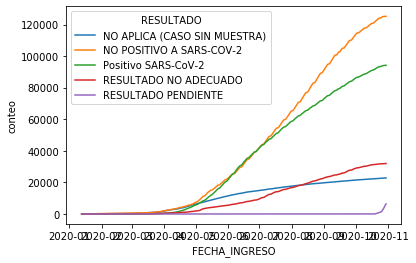

In [ ]:
sns.lineplot(data=test_ent.reset_index(), x='FECHA_INGRESO', y='conteo', hue='RESULTADO')

## calcular_ventana_casos

In [ ]:
# exports
def calcular_ventana_casos(casos_municipios_diarios, dias_ventana=30):
    '''
    Agrega dos columnas: una con los casos acumulados en la ventana de tiempo especificada para la fecha respectiva,
    y la otra con las defuncionas acumuladas en la misma ventana de tiempo.
    '''
    df = casos_municipios_diarios.copy()
    
    df = df.set_index('FECHA_INGRESO')
    df.sort_index(inplace=True)

    rolling_grouping = df.groupby(['CLAVE_MUNICIPIO_RES',
                       'RESULTADO']).rolling(f'{dias_ventana}D')
    
    ventana_df = rolling_grouping[['conteo', 'defunciones']].sum()
    
    ventana_df.rename(columns={'conteo': f'conteo_{dias_ventana}dias',
                       'defunciones': f'defunciones_{dias_ventana}dias'},
            inplace=True)
    
    df = df.merge(ventana_df, on=['CLAVE_MUNICIPIO_RES', 'FECHA_INGRESO', 'RESULTADO'], how='left').reset_index()    
    df = gpd.GeoDataFrame(df, geometry='geometry')
    
    return df


In [ ]:
df = calcular_ventana_casos(mun_covid)

In [ ]:
df = df.query('RESULTADO == "Positivo SARS-CoV-2" & MUNICIPIO_RES == "SAN LUIS POTOSÍ"')
df_long = pd.melt(df, id_vars=['FECHA_INGRESO', 'CLAVE_MUNICIPIO_RES', 'RESULTADO'], value_vars=['conteo', 'defunciones', 'conteo_30dias', 'defunciones_30dias'])

df_long.head()

,FECHA_INGRESO,CLAVE_MUNICIPIO_RES,RESULTADO,variable,value
0,2020-01-13,24028,Positivo SARS-CoV-2,conteo,0.0
1,2020-01-14,24028,Positivo SARS-CoV-2,conteo,0.0
2,2020-01-15,24028,Positivo SARS-CoV-2,conteo,0.0
3,2020-01-16,24028,Positivo SARS-CoV-2,conteo,0.0
4,2020-01-17,24028,Positivo SARS-CoV-2,conteo,0.0


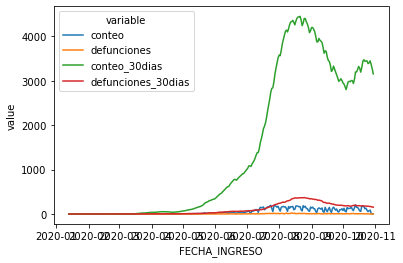

In [ ]:
sns.lineplot(data=df_long,
             x='FECHA_INGRESO', y='value', hue='variable')

In [ ]:
show_doc(calcular_ventana_casos)

<h4 id="calcular_ventana_casos" class="doc_header"><code>calcular_ventana_casos</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>calcular_ventana_casos</code>(**`casos_municipios_diarios`**, **`dias_ventana`**=*`30`*)

Agrega dos columnas: una con los casos acumulados en la ventana de tiempo especificada para la fecha respectiva,
y la otra con las defuncionas acumuladas en la misma ventana de tiempo.

## leer_variables_municipales

In [ ]:
# exports

def leer_variables_municipales():
    variables_municipales = pd.read_csv('datos/municipios/indicadores.csv', index_col=False,
                                        dtype={'cvegeo': str, 'entidad_cv': str,
                                              'municipio_cvegeo': str, 'entidad_cvegeo': str},
                                        encoding='iso8859_2')
    arregla_cvegeo(variables_municipales, 'municipio_cvegeo')
    arregla_cvegeo(variables_municipales, extraer_ent=True)
    
    variables_municipales.drop(columns=['municipio_cvegeo', 'entidad_cv'], inplace=True)
    marco_2019 = gpd.read_file('datos/municipios/marco_2019.json')
    marco_2019.rename(columns={'municipio_cvegeo': 'cvegeo'}, inplace=True)
    # marco_2019 = marco_2019[['municipio_cvegeo', 'geometry', 'municipio_nombre']]
    variables_municipales = variables_municipales.merge(marco_2019, on='cvegeo')
    
    # variables_municipales.drop(columns='nom_mun', inplace=True)
    # variables_municipales.rename(columns={'municipio_nombre': 'nom_mun'}, inplace=True)
    return variables_municipales

In [ ]:
leer_variables_municipales().head()

,cvegeo,nom_ent,pt_2015,an_2015,ne614_015,bi_2015,sins_15,vpt_2015,vns_2015,vna_2015,...,total_camas_publicos,hospitales_privados,total_de_camas_privados,total_camas,pob2020,ent_cvegeo,CVE_ENT,CVE_MUN,municipio_nombre,geometry
0,01001,Aguascalientes,877190,2.0570,3.4786,25.6873,14.1560,0.5478,0.5543,0.6627,...,1228,17,43,1271,961977,01,01,001,Aguascalientes,"POLYGON ((-102.09775 22.02325, -102.11598 22.0..."
1,01002,Aguascalientes,46464,4.4207,2.5959,41.8921,5.5355,1.6779,5.6457,1.2979,...,0,0,0,0,50864,01,01,002,Asientos,"POLYGON ((-102.04348 22.29392, -102.05861 22.3..."
2,01003,Aguascalientes,56048,4.7805,4.3906,49.1856,9.7524,1.0577,0.7756,0.9519,...,46,1,0,46,60760,01,01,003,Calvillo,"POLYGON ((-102.57625 21.96778, -102.59749 22.0..."
3,01004,Aguascalientes,15577,4.3233,2.6265,33.0597,5.1165,1.5629,2.8986,0.5968,...,0,0,0,0,16918,01,01,004,Cosío,"POLYGON ((-102.26605 22.40372, -102.28993 22.4..."
4,01005,Aguascalientes,120405,3.2445,4.1297,33.7271,13.8341,0.9201,1.0273,0.9443,...,297,0,0,297,130184,01,01,005,Jesús María,"POLYGON ((-102.31034 22.03716, -102.33259 22.0..."


## unir_casos_estadisticas_municipales

In [ ]:
# exports
def unir_casos_estadisticas_municipales(casos_municipios_df, estats_municipios):
    cols_com = columnas_comunes(casos_municipios_df, estats_municipios)
    casos_municipios_df = casos_municipios_df.merge(estats_municipios,
                                      left_on=['CLAVE_MUNICIPIO_RES'] + cols_com,
                                      right_on=['cvegeo'] + cols_com, how='right')
    
    casos_municipios_df.drop(columns=['CVE_ENT', 'entidad_cvegeo', 'nom_mun', 'cvegeo',
                                      'nom_ent', 'municipio_nombre', 'id', 'ent_cvegeo', 'pob01'], inplace=True)
    
    return casos_municipios_df

## tabla_covid_indicadores_municipales

In [ ]:
# exports

def tabla_covid_indicadores_municipales(fecha, solo_positivos=True):
    covid_df = carga_datos_covid19_MX(fecha)
    covid_mun_df = agrupa_casos_municipios(covid_df)
    mun_df = leer_variables_municipales()
    mun_df.drop(columns=['geometry'])
    covid_mun_df = unir_casos_estadisticas_municipales(covid_mun_df, mun_df)
    
    if solo_positivos:
        covid_mun_df = covid_mun_df[covid_mun_df.RESULTADO == 'Positivo SARS-CoV-2'] 
    return covid_mun_df

In [ ]:
tabla = tabla_covid_indicadores_municipales('200601')

In [ ]:
tabla.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2465 entries, 2 to 7393
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   CLAVE_MUNICIPIO_RES        2465 non-null   object  
 1   CLAVE_ENTIDAD_RES          2465 non-null   object  
 2   MUNICIPIO_RES              2465 non-null   object  
 3   geometry                   2458 non-null   geometry
 4   RESULTADO                  2465 non-null   object  
 5   ENTIDAD_RES                2465 non-null   object  
 6   conteo                     2465 non-null   float64 
 7   defunciones                2465 non-null   float64 
 8   pt_2015                    2465 non-null   int64   
 9   an_2015                    2454 non-null   float64 
 10  ne614_015                  2454 non-null   float64 
 11  bi_2015                    2454 non-null   float64 
 12  sins_15                    2454 non-null   float64 
 13  vpt_2015                 

In [ ]:
tabla

,CLAVE_MUNICIPIO_RES,CLAVE_ENTIDAD_RES,MUNICIPIO_RES,geometry,RESULTADO,ENTIDAD_RES,conteo,defunciones,pt_2015,an_2015,...,hospitales_semar,hospitales_sedena,hospitales_pemex,total_hospitales_publicos,total_camas_publicos,hospitales_privados,total_de_camas_privados,total_camas,pob2020,CVE_MUN
2,01001,01,AGUASCALIENTES,"POLYGON ((-102.09775 22.02325, -102.11598 22.0...",Positivo SARS-CoV-2,AGUASCALIENTES,652.0,30.0,877190,2.0570,...,0,0,0,8,1228,17,43,1271,961977,001
3,01002,01,ASIENTOS,"POLYGON ((-102.04348 22.29392, -102.05861 22.3...",Positivo SARS-CoV-2,AGUASCALIENTES,8.0,0.0,46464,4.4207,...,0,0,0,0,0,0,0,0,50864,002
7,01003,01,CALVILLO,"POLYGON ((-102.57625 21.96778, -102.59749 22.0...",Positivo SARS-CoV-2,AGUASCALIENTES,11.0,0.0,56048,4.7805,...,0,0,0,1,46,1,0,46,60760,003
11,01004,01,COSÍO,"POLYGON ((-102.26605 22.40372, -102.28993 22.4...",Positivo SARS-CoV-2,AGUASCALIENTES,15.0,0.0,15577,4.3233,...,0,0,0,0,0,0,0,0,16918,004
14,01005,01,JESÚS MARÍA,"POLYGON ((-102.31034 22.03716, -102.33259 22.0...",Positivo SARS-CoV-2,AGUASCALIENTES,30.0,2.0,120405,3.2445,...,0,0,0,1,297,0,0,297,130184,005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,32054,32,VILLA HIDALGO,"POLYGON ((-101.65599 22.51381, -101.67475 22.5...",Positivo SARS-CoV-2,ZACATECAS,1.0,1.0,19155,8.1332,...,0,0,0,0,0,0,0,0,20177,054
7384,32055,32,VILLANUEVA,"POLYGON ((-102.69428 22.62230, -102.70306 22.6...",Positivo SARS-CoV-2,ZACATECAS,2.0,0.0,30240,4.7985,...,0,0,0,1,22,1,0,22,31804,055
7386,32056,32,ZACATECAS,"POLYGON ((-102.58542 22.81149, -102.59311 22.7...",Positivo SARS-CoV-2,ZACATECAS,60.0,4.0,146147,1.2432,...,0,0,0,3,337,5,0,337,155533,056
7390,32057,32,TRANCOSO,"POLYGON ((-102.24610 22.73451, -102.24578 22.7...",Positivo SARS-CoV-2,ZACATECAS,3.0,0.0,19413,5.6122,...,0,0,0,1,12,0,0,12,20285,057


## serie_covid_indicadores_municipales

In [ ]:
# exports
def serie_covid_indicadores_municipales(fecha=None,
                                        covid_df=None,
                                        solo_positivos=True,
                                        acumulativa=True,
                                        dias=30):
    
    if fecha:
        try:
            covid_df = carga_datos_covid19_MX(fecha)
        except KeyError as e:
            print(f'Error con fecha {fecha}')
            print(e)
        
    covid_mun_df = agrupar_casos_municipios_por_fecha(covid_df)
    
    if acumulativa:
        covid_mun_df = calcular_acumulativa_casos(covid_mun_df).reset_index(drop=True)
    else:
        covid_mun_df = calcular_ventana_casos(covid_mun_df, dias)
        
    mun_df = leer_variables_municipales()
    mun_df.drop(columns=['geometry'])
    covid_mun_df = unir_casos_estadisticas_municipales(covid_mun_df, mun_df)
    covid_mun_df.drop(columns='CVE_MUN', inplace=True)
    if solo_positivos:
        covid_mun_df = covid_mun_df[covid_mun_df.RESULTADO == 'Positivo SARS-CoV-2']
    
    covid_mun_df = gpd.GeoDataFrame(covid_mun_df, geometry='geometry')
    return covid_mun_df

    

In [ ]:
serie = serie_covid_indicadores_municipales(covid_df=casos_df, acumulativa=False)

In [ ]:
serie.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 686200 entries, 4 to 3431113
Data columns (total 89 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   FECHA_INGRESO              686200 non-null  datetime64[ns]
 1   ENTIDAD_RES                686200 non-null  object        
 2   CLAVE_ENTIDAD_RES          686200 non-null  object        
 3   MUNICIPIO_RES              686200 non-null  object        
 4   CLAVE_MUNICIPIO_RES        686200 non-null  object        
 5   RESULTADO                  686200 non-null  object        
 6   conteo                     686200 non-null  float64       
 7   defunciones                686200 non-null  float64       
 8   geometry                   684448 non-null  geometry      
 9   conteo_30dias              686200 non-null  float64       
 10  defunciones_30dias         686200 non-null  float64       
 11  pt_2015                    686200 non-null 

In [ ]:
serie = serie_covid_indicadores_municipales(covid_df=casos_df)

In [ ]:
serie.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 686200 entries, 584 to 3430530
Data columns (total 87 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ENTIDAD_RES                686200 non-null  object        
 1   CLAVE_ENTIDAD_RES          686200 non-null  object        
 2   MUNICIPIO_RES              686200 non-null  object        
 3   CLAVE_MUNICIPIO_RES        686200 non-null  object        
 4   RESULTADO                  686200 non-null  object        
 5   FECHA_INGRESO              686200 non-null  datetime64[ns]
 6   conteo                     686200 non-null  float64       
 7   defunciones                686200 non-null  float64       
 8   geometry                   684448 non-null  geometry      
 9   pt_2015                    686200 non-null  int64         
 10  an_2015                    682988 non-null  float64       
 11  ne614_015                  682988 non-nul

## Obtener municipios urbanos

In [ ]:
#exports

def municipios_urbanos():
    archivo = 'datos/municipios/municipios_ciudades.csv'
    
    df = pd.read_csv(archivo, dtype=str)
    df.dropna(inplace=True)
    df.rename(columns={'municipio_cvegeo': "CLAVE_MUNICIPIO"}, inplace=True)
    return df

In [ ]:
municipios_urbanos()

,cve_sun,nom_ciudad,CLAVE_MUNICIPIO
5,1,Aguascalientes,01011
8,4,La Laguna,05017
10,5,Saltillo,05004
19,7,Piedras Negras,05025
21,5,Saltillo,05027
...,...,...,...
2450,56,Zacatecas-Guadalupe,32056
2453,13,Valle de México,09003
2454,13,Valle de México,09010
2455,13,Valle de México,09014


In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_datos.ipynb.
Converted 01_vulnerabilidad.ipynb.
Converted articulo_vulnerabilidad.ipynb.
Converted dump.ipynb.
Converted index.ipynb.
Converted reporte_vulnerabilidad-morbilidades.ipynb.
Converted reporte_vulnerabilidad.ipynb.
